# **Web Scraping Project using Requests and BeautifulSoup**
# The goal is to extract data from the web and save it in an Azure database
# We will target a brazilian retail company, the goal is to extract some data from the products of some departments
# We want to find all the products of a single department first, this is done by searching its pages. We never know how many pages a department has so we need a decision rule to stop the search and change department

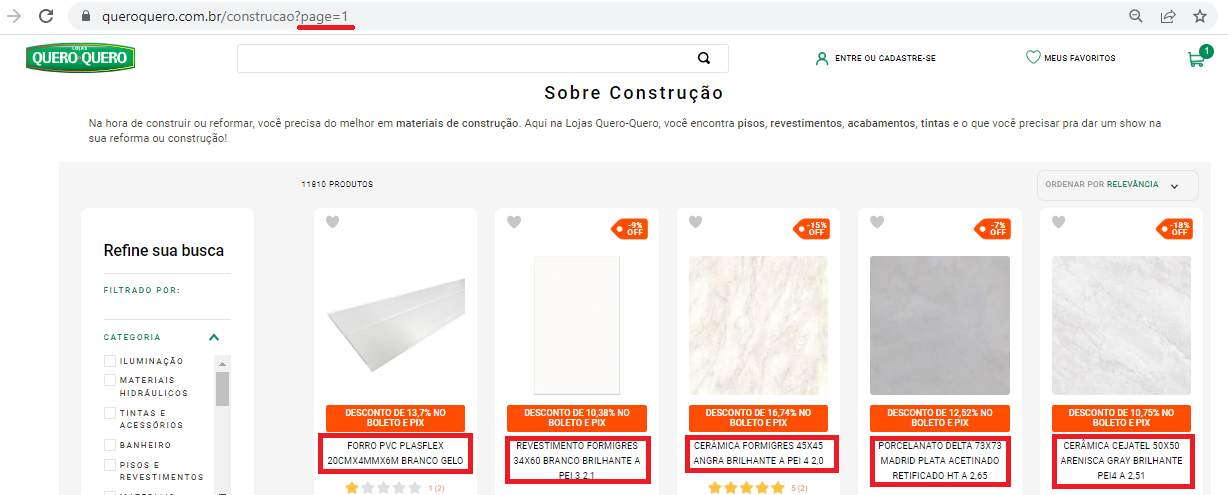

# The data we want from a single product are highlighted in red
# 1) product name
# 2) product price
# 3) product data on installment

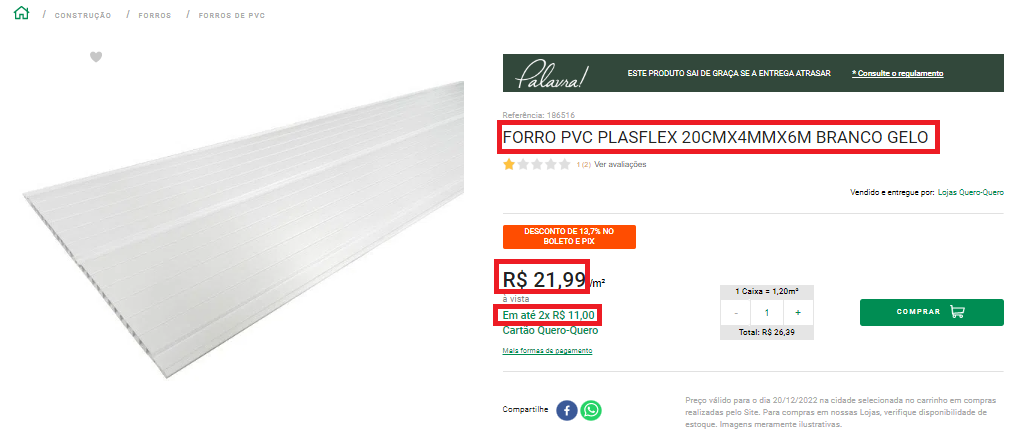

# Install pyodbc, this library is used to connect to Azure

In [2]:
pip install pyodbc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 333 kB 5.3 MB/s 


# Import libraries

In [3]:
import pandas as pd
import requests
import json
import pyodbc

from bs4 import BeautifulSoup
from typing import Tuple

# Create function to get all products from a single department

In [4]:
def get_all_products(department_list: list) -> pd.DataFrame:
    '''
    1) Definition: Function used to get all product from a department 
    
    2) Input: None
            
    3) Return: 
            products_link: List containing the link of all products of the department
    '''

    all_products = pd.DataFrame()

    # Connect to the page
    # Some connections may fail
    
    for count, department in enumerate(department_list, start = 1):
      
      page = 1 # All departments start on page 1
      page_check = list() # We'll use this list to check if we need to change department

      while True:
        
        params = {
            'page': str(page),
        }

        url = 'https://www.queroquero.com.br/' + department
        response = requests.get(url, params=params)

        c = response.content
        soup = BeautifulSoup(c, 'html.parser')
        print('---------------')
        print(f'department = {department} - ({count} / {len(department_list)}) \n')
        print(f'page = {page} \n')

        # Find all products of the page

        elements = soup.find_all("script", {'type': 'application/ld+json'})
        
        if elements and len(elements) > 1:
            products_found = json.loads(elements[1].text)["itemListElement"]
            print(f'products found = {len(products_found)} \n')

            # Check if page has products

            if len(products_found) == 0:
              print(f'no products \n')

            else:
              for i in range(1, len(products_found)):

                  # Find specific product

                  product_link = products_found[i]['item']['@id']

                  # Add product to all_products dataframe

                  row_to_add = {'department': department, 
                                'product_link': product_link}

                  all_products = all_products.append(row_to_add, ignore_index=True)

              page_check.append(True)
              print(f'all_products.shape = {all_products.shape} \n')

        else:
            page_check.append(False)
            print('next product \n')

        # Check pages
        # We'll stop the process if we have 5 pages in a row with no products

        stop_process = page_check[-1 : -6 : -1].count(False) == 5

        if stop_process:
          print(f'stop \n')
          break
            
        # Inscrese page for next iteration

        page += 1

    return all_products


# Create function to access one specific product

In [5]:
def connect_to_product(product_link: str) -> BeautifulSoup:
    '''
    1) Definition: Function used to create soup connected to one product web_link
    
    2) Input:
            product_link: Link of the product we'll access 
            
    3) Return: 
            soup: BeautifulSoup class conected to the link of the product
    '''
    
    headers = {
    'authority': 'www.queroquero.com.br',
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
    'accept-language': 'pt-BR,pt;q=0.9,en-US;q=0.8,en;q=0.7',
    'cache-control': 'max-age=0',
    'if-none-match': '"85E69471837DAAF8E9E0C991C2FA56CC"',
    'referer': 'https://www.queroquero.com.br/construcao',
    'sec-ch-ua': '"Google Chrome";v="107", "Chromium";v="107", "Not=A?Brand";v="24"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"Windows"',
    'sec-fetch-dest': 'document',
    'sec-fetch-mode': 'navigate',
    'sec-fetch-site': 'same-origin',
    'sec-fetch-user': '?1',
    'service-worker-navigation-preload': 'true',
    'upgrade-insecure-requests': '1',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36',
    }

    response = requests.get(
        product_link,
        headers=headers,
    )

    c = response.content
    soup = BeautifulSoup(c, 'html.parser')
    
    return soup

# Create function to get product name

In [6]:
def get_product_name(soup: BeautifulSoup) -> str:
    '''
    1) Definition: Function used to get the name of the product
    
    2) Input:
            soup: BeautifulSoup class created with connect_to_product() function
            
    3) Return: 
            product_name: Name of the product
    '''
    
    #product_name = soup.find_all("span", {"class": "vtex-store-components-3-x-productBrand vtex-store-components-3-x-productBrand--quickview"})[0].text
    product_name = soup.find_all("title")[0].text

    return product_name

# Create function to get product current price

In [7]:
def get_product_current_price(soup: BeautifulSoup) -> float:
    '''
    1) Definition: Function used to get the price of the product
    
    2) Input:
            soup: BeautifulSoup class created with connect_to_product() function
            
    3) Return: 
            product_current_price: Price of the product
    '''
    
    product_current_price = soup.find_all("meta", {"property": "product:price:amount"})[0].get('content')
    product_current_price = float(product_current_price)
    
    return product_current_price

# Create function to get product installment

In [8]:
def get_product_installments(soup: BeautifulSoup) -> Tuple[int, float]:
    '''
    1) Definition: Function used to get the data for credit card payment
    
    2) Input:
            soup: BeautifulSoup class created with connect_to_product() function
            
    3) Return: 
            product_installment: Number of installents allowed for credit card payment
            product_installment_value: Value of each installment
    '''
    
    # Installment 
    
    index = []

    for i in range(0, len(soup.find_all('span'))):
        if soup.find_all('span')[i].has_attr("class"):
            if any('installmentsNumber' in x for x in soup.find_all('span')[i].get('class')):
                index.append(i)        
        
    product_installment = soup.find_all('span')[index[-1]].text
    product_installment = int(product_installment)
        
    # Installment value
    
    index = []

    for i in range(0, len(soup.find_all('span'))):
        if soup.find_all('span')[i].has_attr("class"):
            if any('installmentValue' in x for x in soup.find_all('span')[i].get('class')):
                index.append(i)        
        
    product_installment_value = soup.find_all('span')[index[-1]].text.replace('R$', '').strip().replace(',', '.')
    product_installment_value = float(product_installment_value)
    
    return product_installment, product_installment_value

# Get all products from departments

In [9]:
# I choose only two departments so that the process runs faster

department_list = ['construcao', 'ferramentas']
all_products = get_all_products(department_list) 

---------------
department = construcao - (1 / 2) 

page = 1 

products found = 20 

all_products.shape = (19, 2) 

---------------
department = construcao - (1 / 2) 

page = 2 

products found = 20 

all_products.shape = (38, 2) 

---------------
department = construcao - (1 / 2) 

page = 3 

products found = 20 

all_products.shape = (57, 2) 

---------------
department = construcao - (1 / 2) 

page = 4 

products found = 20 

all_products.shape = (76, 2) 

---------------
department = construcao - (1 / 2) 

page = 5 

products found = 20 

all_products.shape = (95, 2) 

---------------
department = construcao - (1 / 2) 

page = 6 

products found = 20 

all_products.shape = (114, 2) 

---------------
department = construcao - (1 / 2) 

page = 7 

products found = 20 

all_products.shape = (133, 2) 

---------------
department = construcao - (1 / 2) 

page = 8 

products found = 20 

all_products.shape = (152, 2) 

---------------
department = construcao - (1 / 2) 

page = 9 

produc

# Show all_products dataframe

In [10]:
all_products.head()

,department,product_link
0,construcao,https://www.queroquero.com.br/revestimento-for...
1,construcao,https://www.queroquero.com.br/ceramica-formigr...
2,construcao,https://www.queroquero.com.br/porcelanato-delt...
3,construcao,https://www.queroquero.com.br/ceramica-cejatel...
4,construcao,https://www.queroquero.com.br/ceramica-semigre...


In [11]:
all_products.shape

(1824, 2)

In [12]:
all_products['department'].value_counts()

ferramentas    950
construcao     874
Name: department, dtype: int64

# Get data of all product in all_products dataframe, this process takes time

In [13]:
# Create dataframe wich will store all data

data = pd.DataFrame()

# Start iteration

for count, product_link in enumerate(all_products['product_link'], start = 1):
  
  try:

    # Get department

    department = all_products[all_products['product_link'] == product_link]['department'].iloc[0]

    # Connect to product

    soup = connect_to_product(product_link)

    # Get product name

    product_name = get_product_name(soup)

    # Get product price

    product_current_price = get_product_current_price(soup)

    # Get propduct installment

    product_installment, product_installment_price = get_product_installments(soup)

    # Print results

    print('----------------------')
    print(f'product_link_count = {count} / {len(all_products["product_link"])} \n')
    print(f'department = {department} \n')
    print(f'product_link = {product_link} - {type(product_link)} \n')
    print(f'product_name = {product_name} - {type(product_name)} \n')
    print(f'product_current_price = {product_current_price} - {type(product_current_price)} \n')
    print(f'product_installment = {product_installment} - {type(product_installment)} \n')
    print(f'product_installment_price = {product_installment_price} - {type(product_installment_price)} \n')

    # Store all data

    row_to_add = {'department': department,     
                  'product_link': product_link, 
                  'product_name': product_name, 
                  'product_current_price': product_current_price, 
                  'product_installment': product_installment,
                  'product_installment_price': product_installment_price}

    data = data.append(row_to_add, ignore_index=True)

  except:
    pass

A saída de streaming foi truncada nas últimas 5000 linhas.

product_installment = 36 - <class 'int'> 

product_installment_price = 14.63 - <class 'float'> 

----------------------
product_link_count = 1484 / 1824 

department = ferramentas 

product_link = https://www.queroquero.com.br/mangueira-schulz-3-8-9-5mm-10-metros/p - <class 'str'> 

product_name = MANGUEIRA SCHULZ 3/8 9,5MM 10 METROS - <class 'str'> 

product_current_price = 179.9 - <class 'float'> 

product_installment = 26 - <class 'int'> 

product_installment_price = 10.05 - <class 'float'> 

----------------------
product_link_count = 1485 / 1824 

department = ferramentas 

product_link = https://www.queroquero.com.br/escada-santa-catarina-abrir-degrau-deitado-mista-05-degraus-1-50/p - <class 'str'> 

product_name = ESCADA SANTA CATARINA ABRIR DEGRAU DEITADO MISTA 05 DEGRAUS 1.50 - <class 'str'> 

product_current_price = 239.99 - <class 'float'> 

product_installment = 36 - <class 'int'> 

product_installment_price = 10.9

# Show results

In [14]:
data.head(10)

,department,product_link,product_name,product_current_price,product_installment,product_installment_price
0,construcao,https://www.queroquero.com.br/revestimento-for...,REVESTIMENTO FORMIGRES 34X60 BRANCO BRILHANTE ...,28.9,6.0,4.82
1,construcao,https://www.queroquero.com.br/ceramica-formigr...,CERÂMICA FORMIGRES 45X45 ANGRA BRILHANTE A PEI...,23.9,4.0,5.98
2,construcao,https://www.queroquero.com.br/porcelanato-delt...,PORCELANATO DELTA 73X73 MADRID PLATA ACETINADO...,71.9,10.0,7.19
3,construcao,https://www.queroquero.com.br/ceramica-cejatel...,CERÂMICA CEJATEL 50X50 ARENISCA GRAY BRILHANTE...,27.9,7.0,3.99
4,construcao,https://www.queroquero.com.br/ceramica-semigre...,CERÂMICA SEMIGRESS INOUT 74X74 PHD70180R ACETI...,45.9,10.0,4.59
5,construcao,https://www.queroquero.com.br/porcelanato-port...,PORCELANATO PORTOBELLO 90X90 BROADWAY CEMENT N...,123.9,10.0,12.39
6,construcao,https://www.queroquero.com.br/pendente-axell-p...,PENDENTE AXELL PANAMA BRONZEARTE PN3440PDCV2 3...,249.9,36.0,11.42
7,construcao,https://www.queroquero.com.br/revestimento-inc...,REVESTIMENTO INCEFRA 35X70 HDM36680R ACETINADO...,44.9,7.0,6.41
8,construcao,https://www.queroquero.com.br/porcelanato-port...,PORCELANATO PORTINARI 60X60 YORK SGR ACETINADO...,75.9,10.0,7.59
9,construcao,https://www.queroquero.com.br/misturador-docol...,MISTURADOR DOCOL 00905657 MONOCOMANDO COZINHA ...,999.9,36.0,45.73


In [15]:
data.shape

(1762, 6)

# Make sure you save the dataframe, creating it takes a long time

In [ ]:
data.to_csv('data.csv', sep = ';')

# Send all data do Cloud Azure SQL

In [34]:
# If you get an error concerning the driver, check https://stackoverflow.com/questions/61519253/pyodbc-on-google-colab
# run these commands:
# %%sh
# curl https://packages.microsoft.com/keys/microsoft.asc | apt-key add -
# curl https://packages.microsoft.com/config/ubuntu/16.04/prod.list > /etc/apt/sources.list.d/mssql-release.list
# sudo apt-get update
# sudo ACCEPT_EULA=Y apt-get -q -y install msodbcsql17

# Create connection with Azure
# This is VERY sensitive data, it's NOT advisable to keep it in the code

driver = '{ODBC Driver 17 for SQL Server}'
server = 'webcrapingserver.database.windows.net'  
database = 'web_scraping_database' 
username = 'web_scraping' 
password = 'project123!' 

connection = pyodbc.connect(driver = driver,
                            server = server,
                            database = database,
                            uid = username, 
                            pwd = password)

cursor = connection.cursor()


In [20]:
# Insert Dataframe into Azure database

for index, row in data.iterrows():
    print(f'\nindex = {index} / {len(data)}')

    query = '''INSERT INTO scraping_results
               (department, product_link, product_name, product_current_price, product_installment, product_installment_price) 
               values(?, ?, ?, ?, ?, ?)'''

    department = row['department']
    product_link = row['product_link']
    product_name = row['product_name']
    product_current_price = row['product_current_price']
    product_installment = row['product_installment']
    product_installment_price = row['product_installment_price']
  
    print(f'department = {department} - type = {type(department)}')
    print(f'product_link = {product_link} - type = {type(product_link)}')
    print(f'product_name = {product_name} - type = {type(product_name)}')
    print(f'product_current_price = {product_current_price} - type = {type(product_current_price)}')
    print(f'product_installment = {product_installment} - type = {type(product_installment)}')
    print(f'product_installment_price = {product_installment_price} - type = {type(product_installment_price)}')

    values = department, product_link, product_name, product_current_price, product_installment, product_installment_price

    cursor.execute(query, values)

connection.commit()
cursor.close() 

A saída de streaming foi truncada nas últimas 5000 linhas.

index = 1137 / 1762
department = ferramentas - type = <class 'str'>
product_link = https://www.queroquero.com.br/tupia-skil-1831-1100w-220v/p - type = <class 'str'>
product_name = TUPIA SKIL 1831 1100W 220V - type = <class 'str'>
product_current_price = 999.9 - type = <class 'float'>
product_installment = 36.0 - type = <class 'float'>
product_installment_price = 45.73 - type = <class 'float'>

index = 1138 / 1762
department = ferramentas - type = <class 'str'>
product_link = https://www.queroquero.com.br/suporte-furadeira-ferrari-sfp10am-c-morsa/p - type = <class 'str'>
product_name = SUPORTE FURADEIRA FERRARI SFP10AM C/MORSA - type = <class 'str'>
product_current_price = 304.9 - type = <class 'float'>
product_installment = 36.0 - type = <class 'float'>
product_installment_price = 13.94 - type = <class 'float'>

index = 1139 / 1762
department = ferramentas - type = <class 'str'>
product_link = https://www.queroquero.com.br/dis

# Validate if the data was sent to the cloud

In [37]:
df = pd.read_sql(sql = query, con = connection)

In [38]:
df.head()

,department,product_link,product_name,product_current_price,product_installment,product_installment_price
0,construcao,https://www.queroquero.com.br/piso-vinilico-ta...,"PISO VINILICO TARKETT INJOY LICHIA 20,8X124X0,...",95.0,10,9.0
1,construcao,https://www.queroquero.com.br/lampada-led-tasc...,LAMPADA LED TASCHIBRA TKL900/60 6500K,10.0,1,10.0
2,construcao,https://www.queroquero.com.br/forro-pvc-plasbi...,FORRO PVC PLASBIL LISO 2001 JUNTA SECA 20CMX10...,55.0,5,11.0
3,construcao,https://www.queroquero.com.br/ceramica-formigr...,CERÂMICA FORMIGRES 50X50 ANDARAÍ CL BRILHANTE ...,32.0,7,5.0
4,construcao,https://www.queroquero.com.br/vaso-incepa-zip-...,VASO INCEPA ZIP CAIXA ACOPLADA ECOFLUSH BRANCO,410.0,36,19.0


# Show results in the cloud

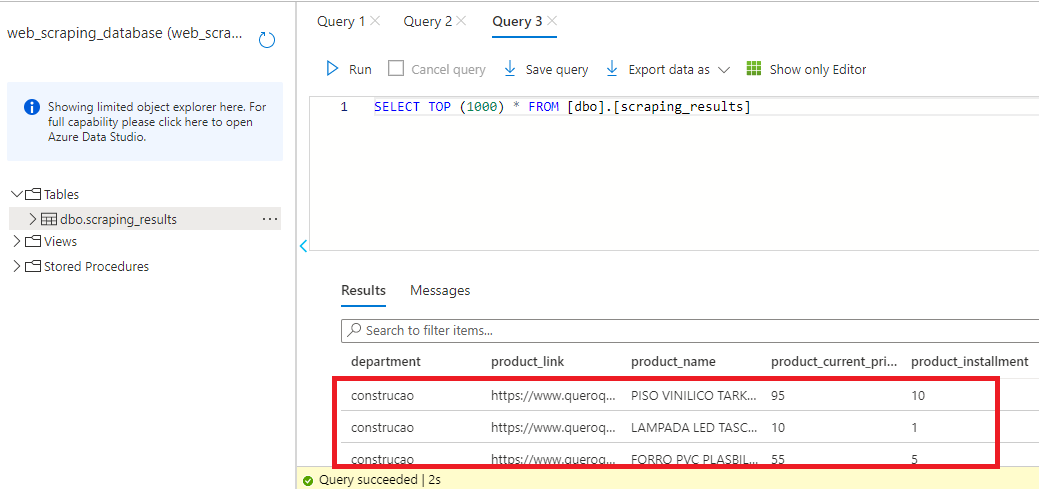